# Projeto de TCC
**Autor**: Igor Sousa dos Santos Santana

**Data**: 2024-07-26

## Índice

- [Importando pacotes e Bibliotecas](#importando-pacotes-e-bibliotecas)
- [Importando os Datasets](#importando-os-datasets)
- [Breve Apresentação dos Datasets](#breve-apresentacao-dos-datasets)
- [Análise Exploratória de Dados](#aed)
    - [Dataset Iris](#dataset-iris)
    - [Dataset Titanic](#dataset-titanic)
- [Preparação dos parâmetros](#preparando-os-hiper-parâmetros)
- [Algoritmo KMeans](#utilizando-o-algoritmo-kmeans)
- [Algoritmo MeanShift](#utilizando-o-algoritmo-meanshift)
- [Algoritmo FuzzyCMeans](#usando-o-algoritmo-fuzzycmeans)
- [Bibliografia](#bibliografia)

## Importando pacotes e Bibliotecas

In [255]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.utils import resample
from fcmeans import FCM
import seaborn as sns
import pandas as pd
import numpy as np

## Importando os Datasets

In [256]:
df_iris_raw = pd.read_csv("./databases/raw/Iris.csv", sep = ",", index_col = "Id")
df_titanic_raw = pd.read_csv("./databases/raw/titanic.csv", sep = ",", index_col = "PassengerId")

## Breve apresentacao dos datasets

In [257]:
df_iris_raw.sample(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
64,6.1,2.9,4.7,1.4,Iris-versicolor
135,6.1,2.6,5.6,1.4,Iris-virginica
122,5.6,2.8,4.9,2.0,Iris-virginica
65,5.6,2.9,3.6,1.3,Iris-versicolor
96,5.7,3.0,4.2,1.2,Iris-versicolor
120,6.0,2.2,5.0,1.5,Iris-virginica
115,5.8,2.8,5.1,2.4,Iris-virginica
42,4.5,2.3,1.3,0.3,Iris-setosa
126,7.2,3.2,6.0,1.8,Iris-virginica


In [258]:
df_titanic_raw.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S
415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S
394,1,1,"Newell, Miss. Marjorie",female,23.0,1,0,35273,113.2750,D36,C
571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S
554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C
377,1,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,C 7077,7.2500,NaN,S
422,0,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q
39,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0000,NaN,S
551,1,1,"Thayer, Mr. John Borland Jr",male,17.0,0,2,17421,110.8833,C70,C


In [259]:
df_iris_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [260]:
df_titanic_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


No dataset Titanic, podemos ver que há dados faltantes em diversas colunas.

Será realizado um análise e um possível limpeza nesses dados.

### Limpeza dos dados no dataset Titanic

In [261]:
df_titanic_raw.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

#### Verificando colunas probemáticas

In [262]:
print(df_titanic_raw["Age"].head(10))
print(df_titanic_raw["Cabin"].head(10))
print(df_titanic_raw["Embarked"].head(10))

PassengerId
1     22.0
2     38.0
3     26.0
4     35.0
5     35.0
6      NaN
7     54.0
8      2.0
9     27.0
10    14.0
Name: Age, dtype: float64
PassengerId
1      NaN
2      C85
3      NaN
4     C123
5      NaN
6      NaN
7      E46
8      NaN
9      NaN
10     NaN
Name: Cabin, dtype: object
PassengerId
1     S
2     C
3     S
4     S
5     S
6     Q
7     S
8     S
9     S
10    C
Name: Embarked, dtype: object


Foi após análise visual, foi decidido:
- deletar a coluna "Cabin";
- preencher a coluna "Embarked";
    - Utilizando a moda.
- preenchar a coluna "Age".
    - Utilizando a mediana.

#### Realizando mudanças no dataset

In [263]:
df_titanic_raw["Embarked"].mode()

0    S
Name: Embarked, dtype: object

In [264]:
df_titanic_processed = df_titanic_raw.drop(columns = ["Cabin"], axis = "columns")
df_titanic_processed["Age"] = df_titanic_processed["Age"].fillna(df_titanic_processed["Age"].median())
df_titanic_processed["Embarked"] = df_titanic_processed["Embarked"].fillna("S")
df_titanic_processed.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

#### Descartando colunas vistas como inúteis para a análise dos dados

In [265]:
colunas_para_descartar = [
    "Parch",
    "Ticket"
]

In [266]:
df_titanic_processed.drop(columns = colunas_para_descartar, axis = "column", inplace = True)

#### Mudanças nos tipos do dado do dataset Titanic

In [267]:
df_titanic_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 62.6+ KB


As colunas:
- Survived;
- Pclass;
- Sex;
- Embarked.

Serão classificadas como tipo "categórico"(category).

As colunas:
- SibSp;
- Age.

Serão classificadas como tipo "inteiro"(uint8).

A coluna "Fare" será classificada como tipo ponto flutuante (float32).

A coluna "Name" será classificada como tipo alfanumérico (str).

In [268]:
df_titanic_processed["Survived"]    = df_titanic_processed["Survived"].astype("category")
df_titanic_processed["Pclass"]      = df_titanic_processed["Pclass"].astype("category")
df_titanic_processed["Name"]        = df_titanic_processed["Name"].astype("string")
df_titanic_processed["Sex"]         = df_titanic_processed["Sex"].astype("category")
df_titanic_processed["Age"]         = df_titanic_processed["Age"].astype("uint8")
df_titanic_processed["SibSp"]       = df_titanic_processed["SibSp"].astype("uint8")
df_titanic_processed["Fare"]        = df_titanic_processed["Fare"].astype("float32")
df_titanic_processed["Embarked"]    = df_titanic_processed["Embarked"].astype("category")

##### Verificando mudança

In [269]:
df_titanic_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Name      891 non-null    string  
 3   Sex       891 non-null    category
 4   Age       891 non-null    uint8   
 5   SibSp     891 non-null    uint8   
 6   Fare      891 non-null    float32 
 7   Embarked  891 non-null    category
dtypes: category(4), float32(1), string(1), uint8(2)
memory usage: 23.1 KB


#### Mudanças no valores da coluna "Sex"

In [270]:
df_titanic_processed["Sex"].unique()

['male', 'female']
Categories (2, object): ['female', 'male']

Para melhor manipulação do dataset, foi escolhido manter os dados categóricos seguindo a
convenção de números inteiros, pequenos e positivos, como é possível notar nas colunas
"Survived" e "Pclass".

Portanto será realizado uma manipulação dos dados, de forma que:
- ` female ` será substituido pelo número ` 0 `;
- ` male ` será substituido pelo número ` 1 `.

In [271]:
novos_valores_Sex = {
    "female": 0,
    "male": 1
}

In [272]:
df_titanic_processed["Sex"] = df_titanic_processed["Sex"].map(novos_valores_Sex)
df_titanic_processed["Sex"].unique()

[1, 0]
Categories (2, int64): [0, 1]

#### Mudanças no valores da coluna "Embarked"

In [273]:
df_titanic_processed["Embarked"].unique()

['S', 'C', 'Q']
Categories (3, object): ['C', 'Q', 'S']

Para melhor manipulação do dataset, foi escolhido manter os dados categóricos seguindo a
convenção de números inteiros, pequenos e positivos, como é possível notar nas colunas
"Sex", "Survived" e "Pclass".

Portanto será realizado uma manipulação dos dados, de forma que:
- ` C ` será substituido pelo número ` 0 `;
- ` Q ` será substituido pelo número ` 1 `;
- ` S ` será substituido pelo número ` 2 `.

In [274]:
novos_valores_Embarked = {
    "C": 0,
    "Q": 1,
    "S": 2
}

In [275]:
df_titanic_processed["Embarked"] = df_titanic_processed["Embarked"].map(novos_valores_Embarked)
df_titanic_processed["Embarked"].unique()

[2, 0, 1]
Categories (3, int64): [0, 1, 2]

#### Verificando se os dados da coluna "Pclass" estão balanceados

In [276]:
df_titanic_processed["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Como podemos ver acima, os dados estão muito desbalanceados.

Para uma melhor análise, será preciso reabalancear os dados, ou para mais ou para menos.
Se balancearmos para menos, perderemos uma quantidade enorme de dados, então foi escolhido balancear para mais.

##### Gerando vários datasets para balancear os dados

###### Hiper parametros

In [277]:
tamanho_das_classes = df_titanic_processed[df_titanic_processed["Pclass"] == 3].shape[0]
semente_randomica = 42

###### Realizando a criação

In [278]:
df_Pclass_1 = df_titanic_processed[df_titanic_processed["Pclass"] == 1]
df_Pclass_2 = df_titanic_processed[df_titanic_processed["Pclass"] == 2]
df_Pclass_3 = df_titanic_processed[df_titanic_processed["Pclass"] == 3]

###### Realizando a balanceamento

In [279]:
df_Pclass_1 = resample(df_Pclass_1,
                       replace = True,
                       n_samples = tamanho_das_classes,
                       random_state = semente_randomica)
df_Pclass_2 = resample(df_Pclass_2,
                       replace = True,
                       n_samples = tamanho_das_classes,
                       random_state = semente_randomica)

##### Unindo os datasets em um só

In [280]:
df_titanic_processed_balanceado = pd.concat([df_Pclass_3, df_Pclass_1, df_Pclass_2])
df_titanic_processed_balanceado["Pclass"].value_counts()

Pclass
1    491
2    491
3    491
Name: count, dtype: int64

#### Salvando o dataset tratado em um pickle (.pkl)

In [281]:
df_titanic_processed_balanceado.to_pickle("./databases/processed/titatic_processado.pkl")

#### Lendo o dataset tratado

In [282]:
df_titanic_processed = pd.read_pickle("./databases/processed/titatic_processado.pkl")

## AED

### Dataset Iris

In [283]:
df_frequencia_distribuicao_especies = pd.crosstab(index = df_iris_raw["Species"], columns = "quantidade")
df_frequencia_distribuicao_especies

col_0,quantidade
Species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


#### Separando as especies em datasets especificos

In [284]:
df_setosa = df_iris_raw.loc[df_iris_raw["Species"] == "Iris-setosa"]
df_versicolor = df_iris_raw.loc[df_iris_raw["Species"] == "Iris-versicolor"]
df_virginica = df_iris_raw.loc[df_iris_raw["Species"] == "Iris-virginica"]

#### Imprimindo os gráficos

##### Histograma

<Figure size 2000x1200 with 0 Axes>

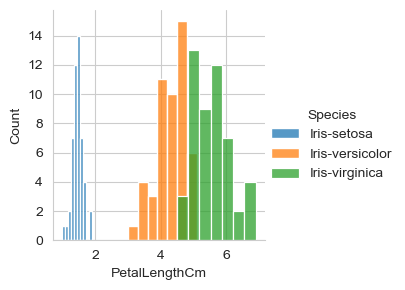

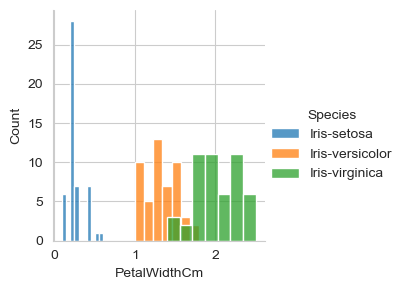

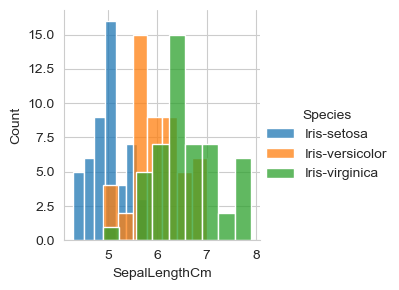

In [285]:
plt.figure(figsize = (20, 12))

sns.FacetGrid(df_iris_raw, hue = "Species", height = 3).map(sns.histplot, "PetalLengthCm").add_legend()
sns.FacetGrid(df_iris_raw, hue = "Species", height = 3).map(sns.histplot, "PetalWidthCm").add_legend()
sns.FacetGrid(df_iris_raw, hue = "Species", height = 3).map(sns.histplot, "SepalLengthCm").add_legend()

plt.show()

##### Boxplot

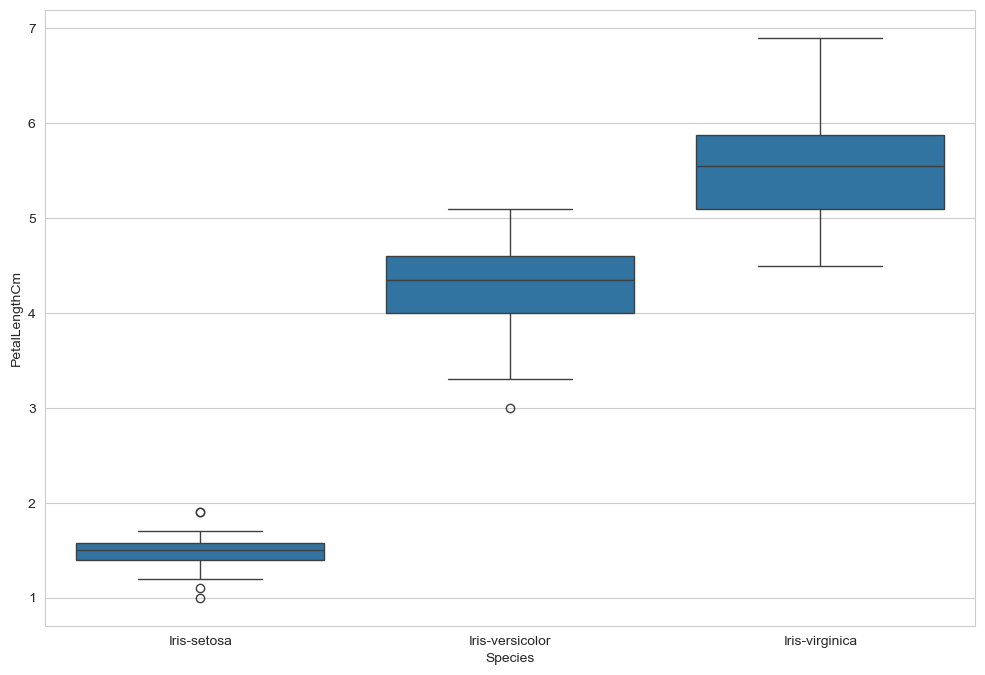

In [286]:
plt.figure(figsize = (12, 8))

sns.boxplot(data = df_iris_raw, x = "Species", y = "PetalLengthCm")

plt.show()

##### Violinplot

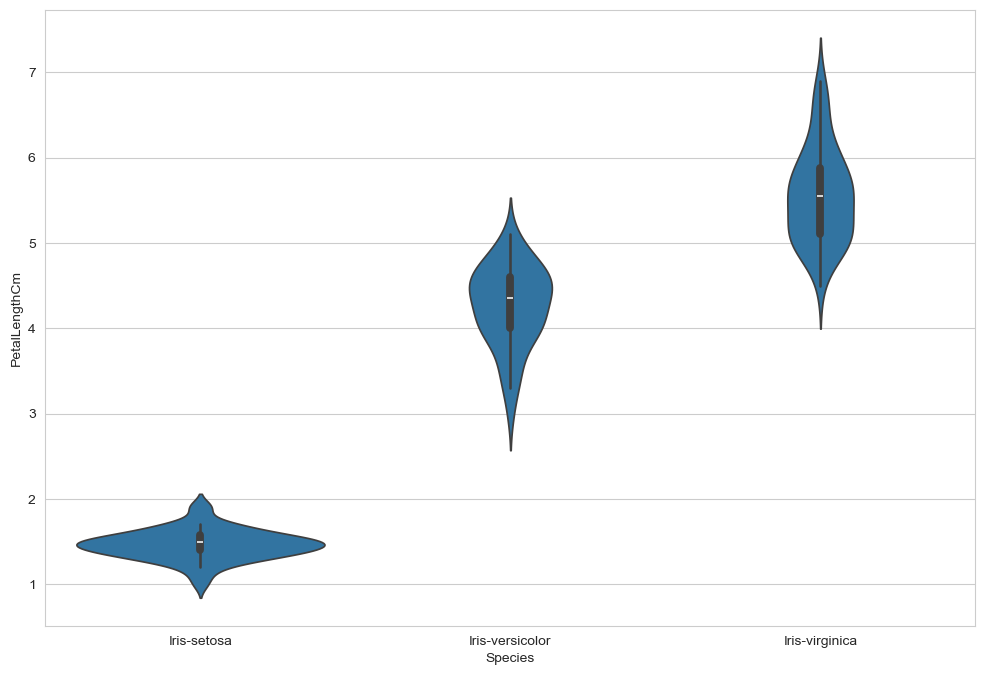

In [287]:
plt.figure(figsize = (12, 8))

sns.violinplot(data = df_iris_raw, x = "Species", y = "PetalLengthCm")

plt.show()

##### Gráfico de dispersão

<Figure size 2000x1200 with 0 Axes>

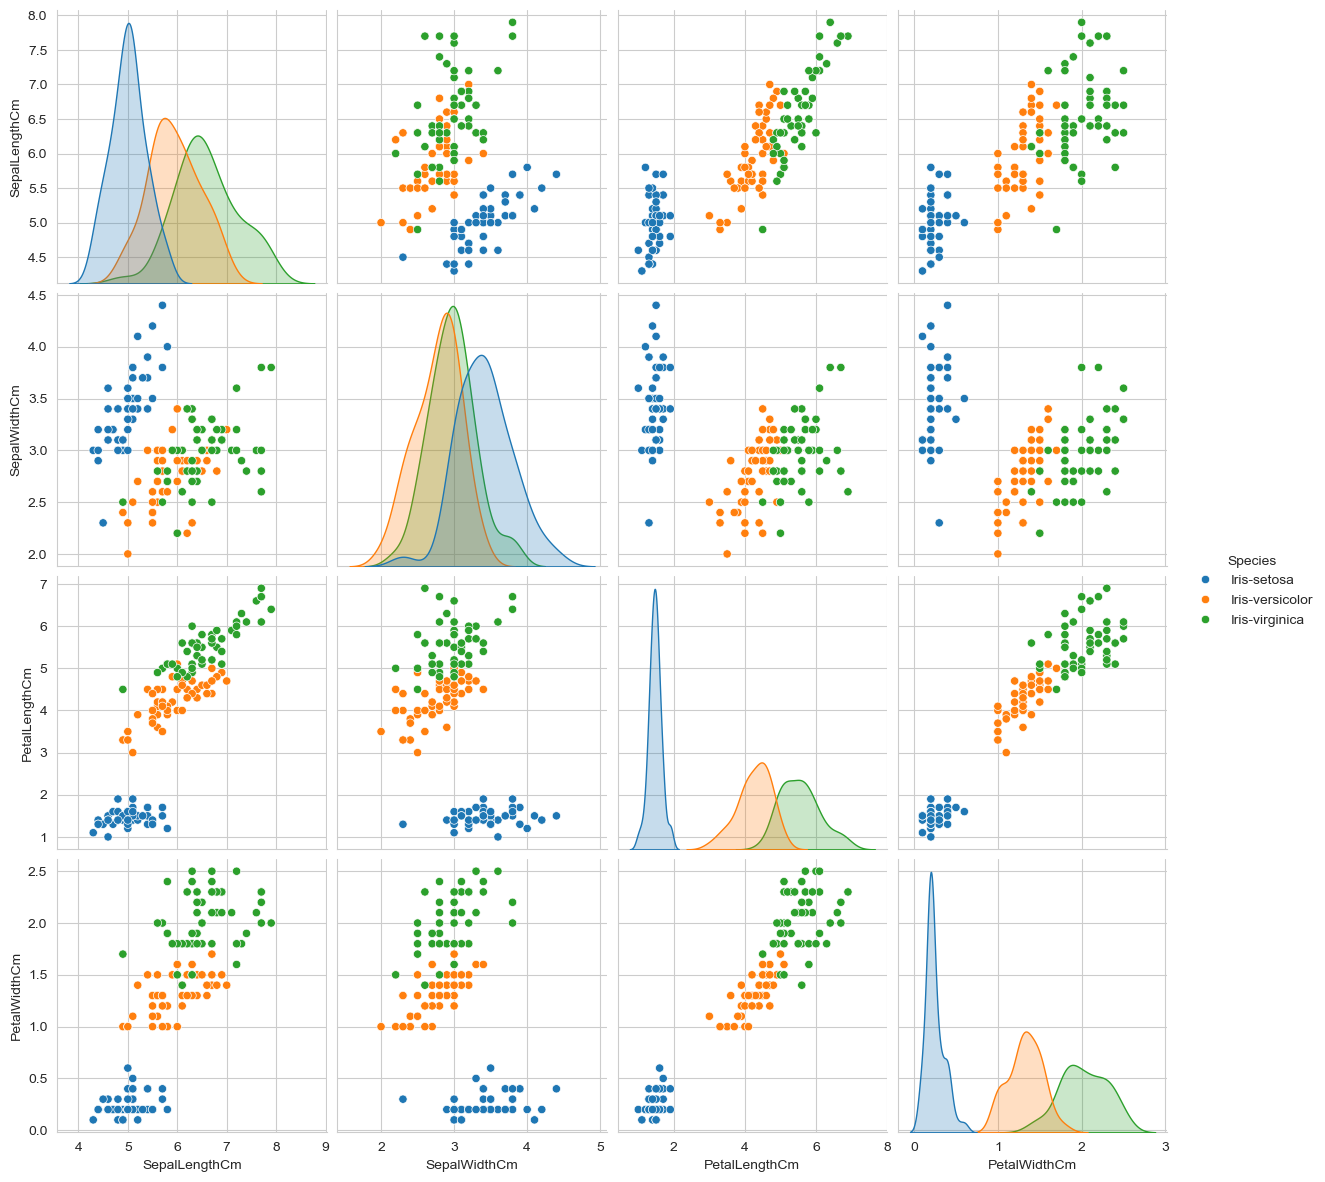

In [288]:
plt.figure(figsize = (20, 12))

sns.set_style("whitegrid")
sns.pairplot(df_iris_raw, hue = "Species", height = 3)

plt.show()

### Dataset Titanic

In [289]:
df_frequencia_distribuicao_classes = pd.crosstab(index = df_titanic_processed["Pclass"], columns = "quantidade")
df_frequencia_distribuicao_classes

col_0,quantidade
Pclass,
1,491
2,491
3,491


#### Separando as classes em datasets especificos

In [290]:
df_Pclass_1 = df_titanic_processed.loc[df_titanic_processed["Pclass"] == 1]
df_Pclass_2 = df_titanic_processed.loc[df_titanic_processed["Pclass"] == 2]
df_Pclass_3 = df_titanic_processed.loc[df_titanic_processed["Pclass"] == 3]

#### Imprimindo os gráficos

##### Histograma

<Figure size 2000x1200 with 0 Axes>

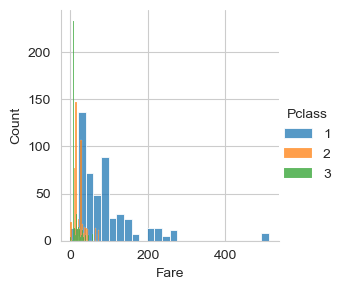

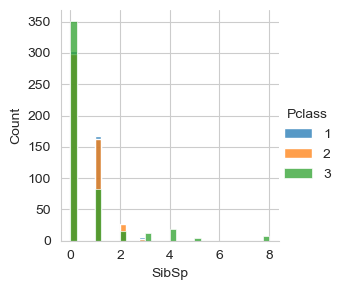

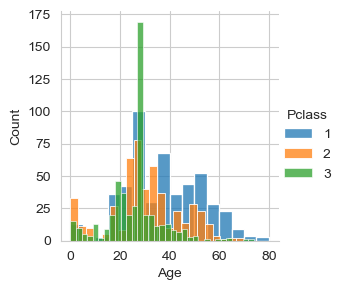

In [291]:
plt.figure(figsize = (20, 12))

sns.FacetGrid(df_titanic_processed, hue = "Pclass", height = 3).map(sns.histplot, "Fare").add_legend()
sns.FacetGrid(df_titanic_processed, hue = "Pclass", height = 3).map(sns.histplot, "SibSp").add_legend()
sns.FacetGrid(df_titanic_processed, hue = "Pclass", height = 3).map(sns.histplot, "Age").add_legend()

plt.show()

##### Boxplot

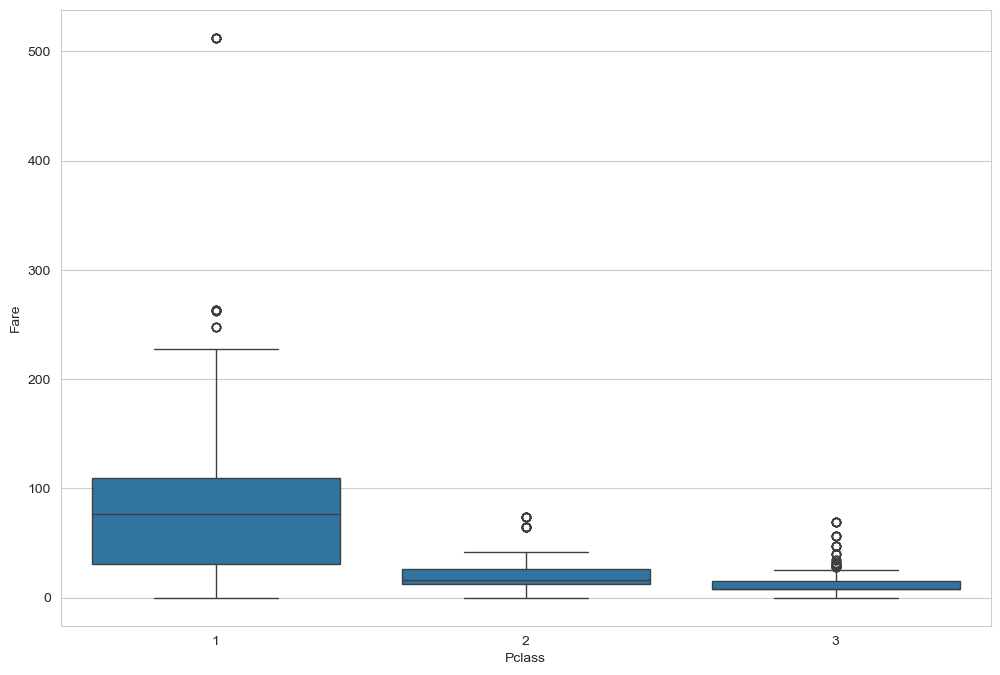

In [292]:
plt.figure(figsize = (12, 8))

sns.boxplot(data = df_titanic_processed, x = "Pclass", y = "Fare")

plt.show()

##### Violinplot

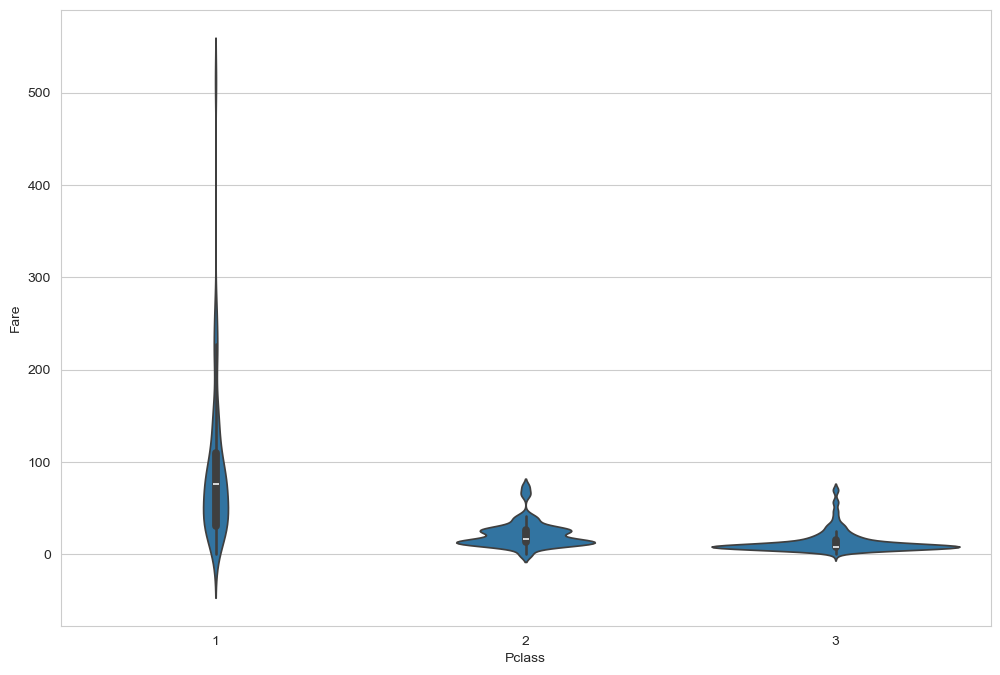

In [293]:
plt.figure(figsize = (12, 8))

sns.violinplot(data = df_titanic_processed, x = "Pclass", y = "Fare")

plt.show()

##### Gráfico de dispersão

<Figure size 2000x1200 with 0 Axes>

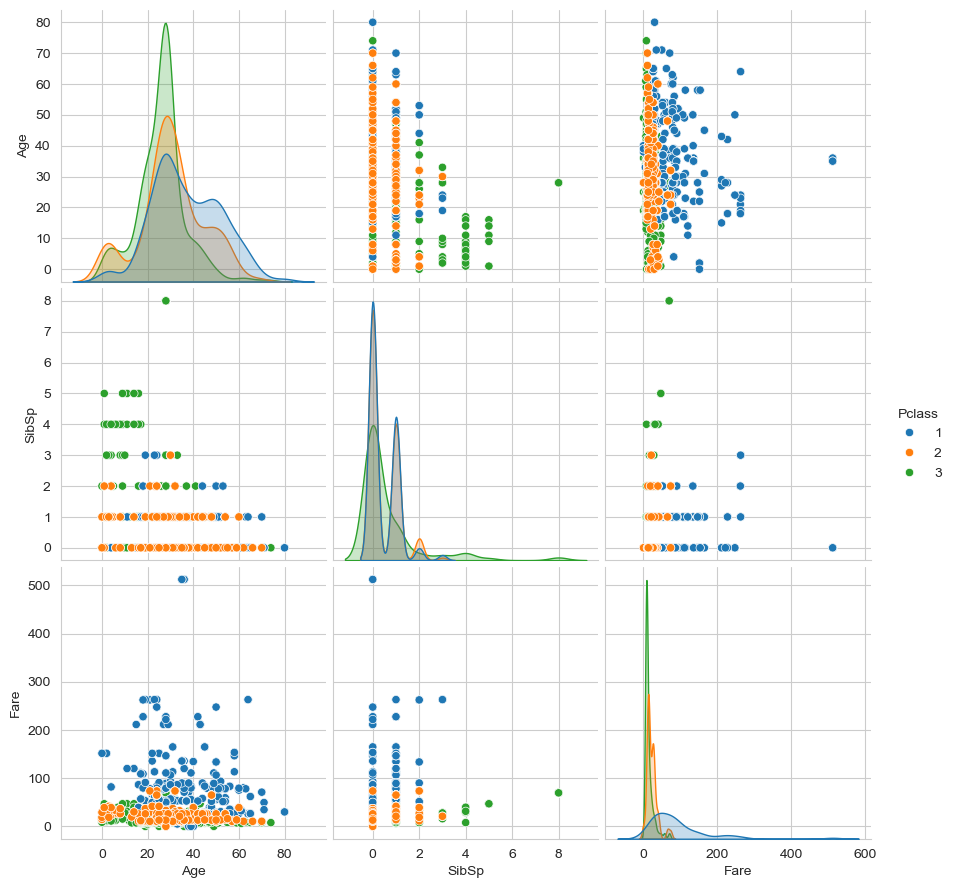

In [294]:
plt.figure(figsize = (20, 12))

sns.set_style("whitegrid")
sns.pairplot(df_titanic_processed, hue = "Pclass", height = 3)

plt.show()

## Preparando os hiper parâmetros

In [295]:
X_iris = df_iris_raw.drop(columns = ["Species"]).values
y_iris = df_iris_raw["Species"]

standartScaler = StandardScaler()
X_titanic = standartScaler.fit_transform(df_titanic_processed.drop(columns = ["Pclass", "Name"]).values)
y_titanic = df_titanic_processed["Pclass"]

In [296]:
nro_max_iteracoes = 300
nro_iteracoes_inicial = 10
semente_randomica = 42

## Utilizando o algoritmo Kmeans

In [297]:
soma_dos_quadrados_iris = []
soma_dos_quadrados_titanic = []

for i in range (1, 14):
    kmeans = KMeans(n_clusters = i,
                    init = "k-means++",
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)
    kmeans.fit(X_iris)
    soma_dos_quadrados_iris.append(kmeans.inertia_)
    
    kmeans = KMeans(n_clusters = i,
                    init = "k-means++",
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)
    kmeans.fit(X_titanic)
    soma_dos_quadrados_titanic.append(kmeans.inertia_)

### Imprimindo o resultado dos testes

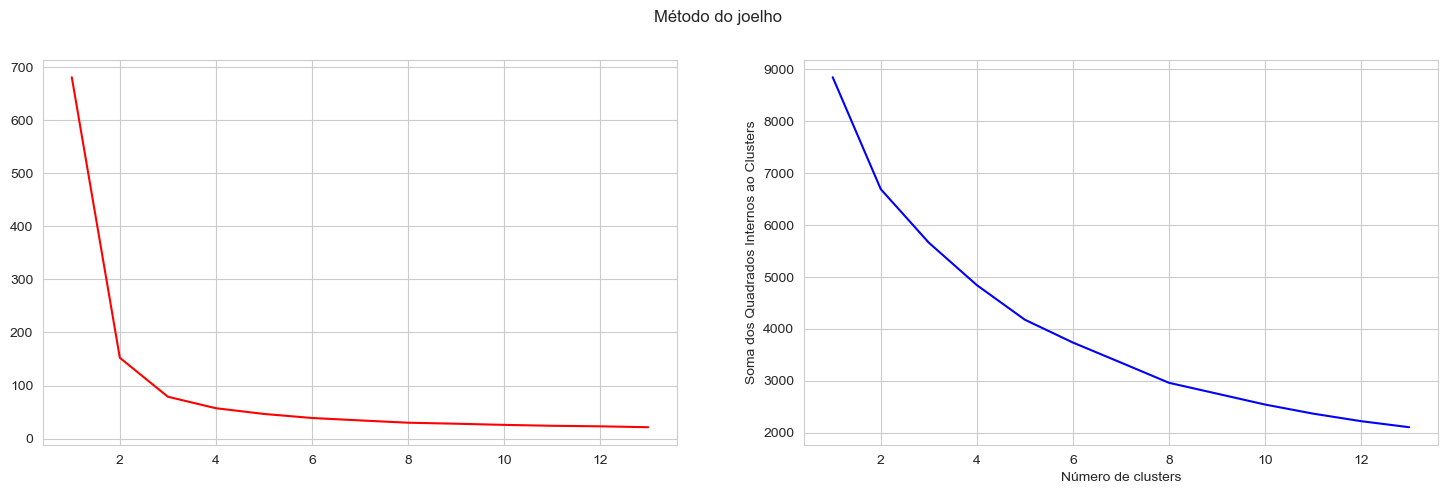

In [298]:
figura, eixos = plt.subplots(1, 2, figsize = (18, 5))

plt.suptitle("Método do joelho")
plt.xlabel("Número de clusters")
plt.ylabel("Soma dos Quadrados Internos ao Clusters")

eixos[0].plot(range(1, 14), soma_dos_quadrados_iris, color = "red")
eixos[1].plot(range(1, 14), soma_dos_quadrados_titanic, color = "blue")

plt.show()

No caso acima, o resultado a partir do número 3 decai muito, portanto o número de clusters escolhido é:
- `3` para o dataset `Iris`;
- `3` para o dataset `Titanic`.

### Implementando a clusterização

#### Dataset Iris

In [299]:
kmeans_iris = KMeans(n_clusters = 3,
                    init = "k-means++",
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)
y_kmeans_iris = kmeans_iris.fit_predict(X_iris)

#### Dataset Titanic

In [300]:
kmeans_titanic = KMeans(n_clusters = 3,
                        init = "k-means++",
                        max_iter = nro_max_iteracoes,
                        n_init = nro_iteracoes_inicial,
                        random_state = semente_randomica)
y_kmeans_titanic = kmeans_titanic.fit_predict(X_titanic)

##### Visualizando os clusters

###### De forma 2D

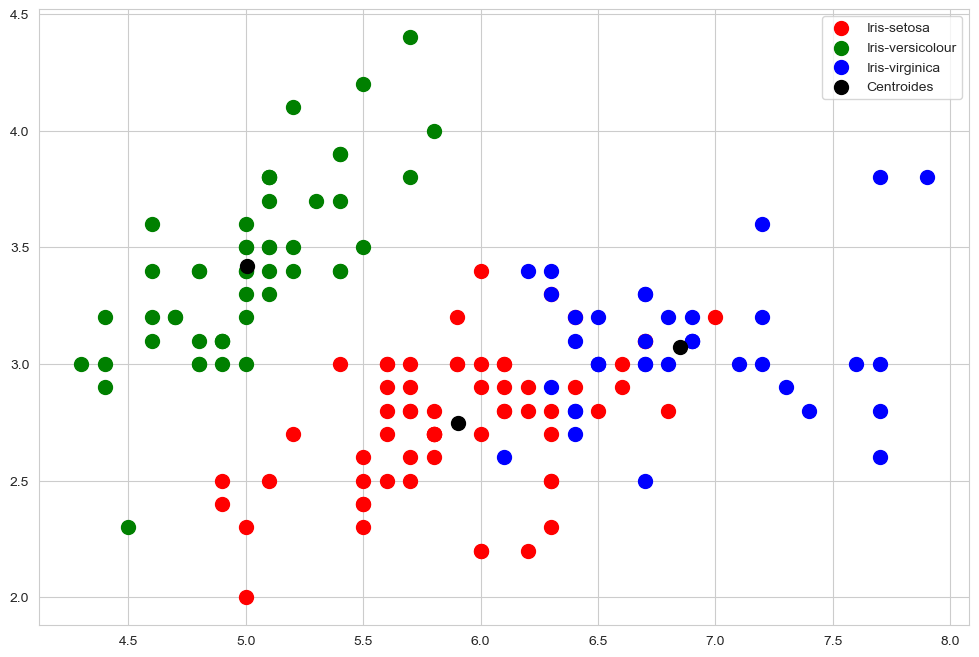

In [301]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_iris.cluster_centers_[:, 0], kmeans_iris.cluster_centers_[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

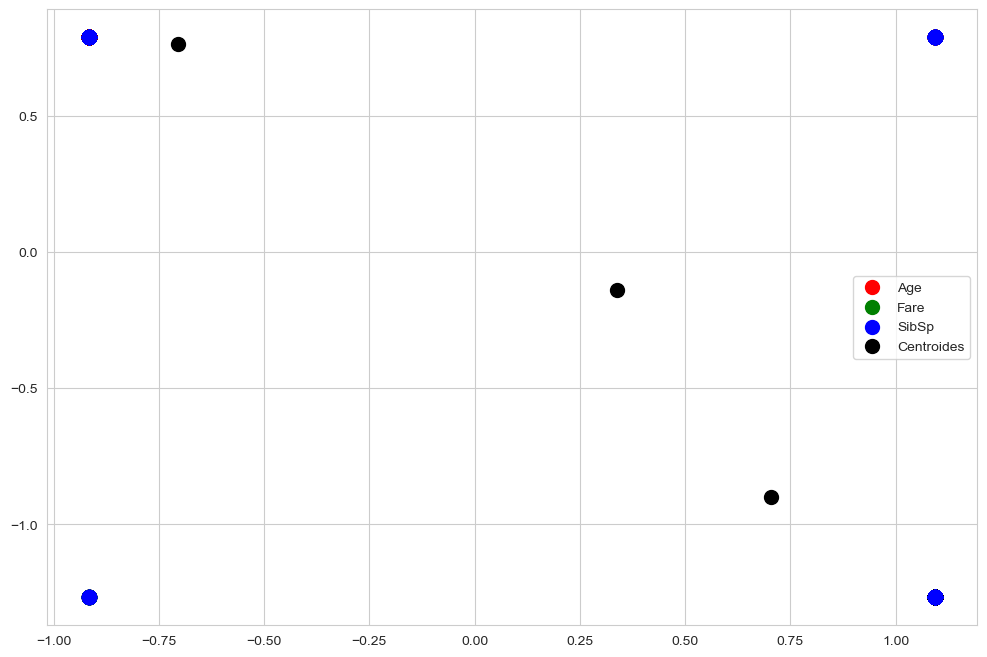

In [302]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "red", label = "Age")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "green", label = "Fare")
plt.scatter(X_titanic[y_kmeans_titanic == 2, 0], X_titanic[y_kmeans_titanic == 2, 1], s = 100, c = "blue", label = "SibSp")

### OS CENTROIDES
plt.scatter(kmeans_titanic.cluster_centers_[:, 0], kmeans_titanic.cluster_centers_[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

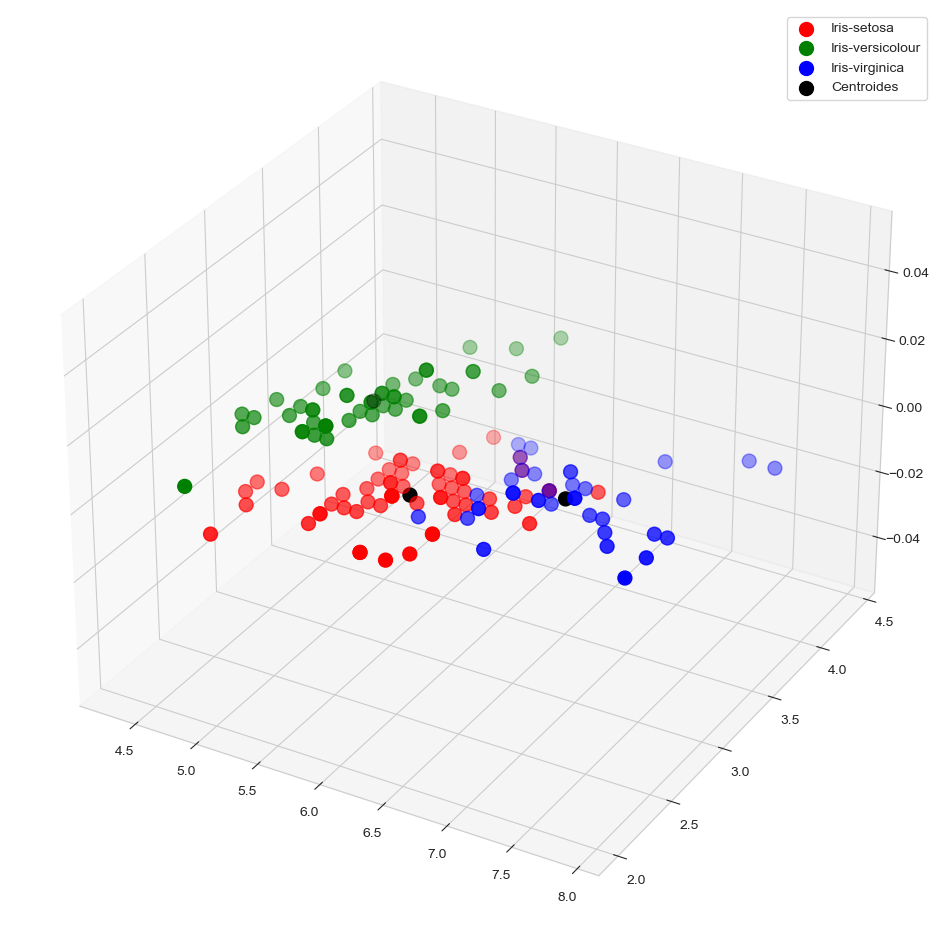

In [303]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_iris.cluster_centers_[:, 0], kmeans_iris.cluster_centers_[:,1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

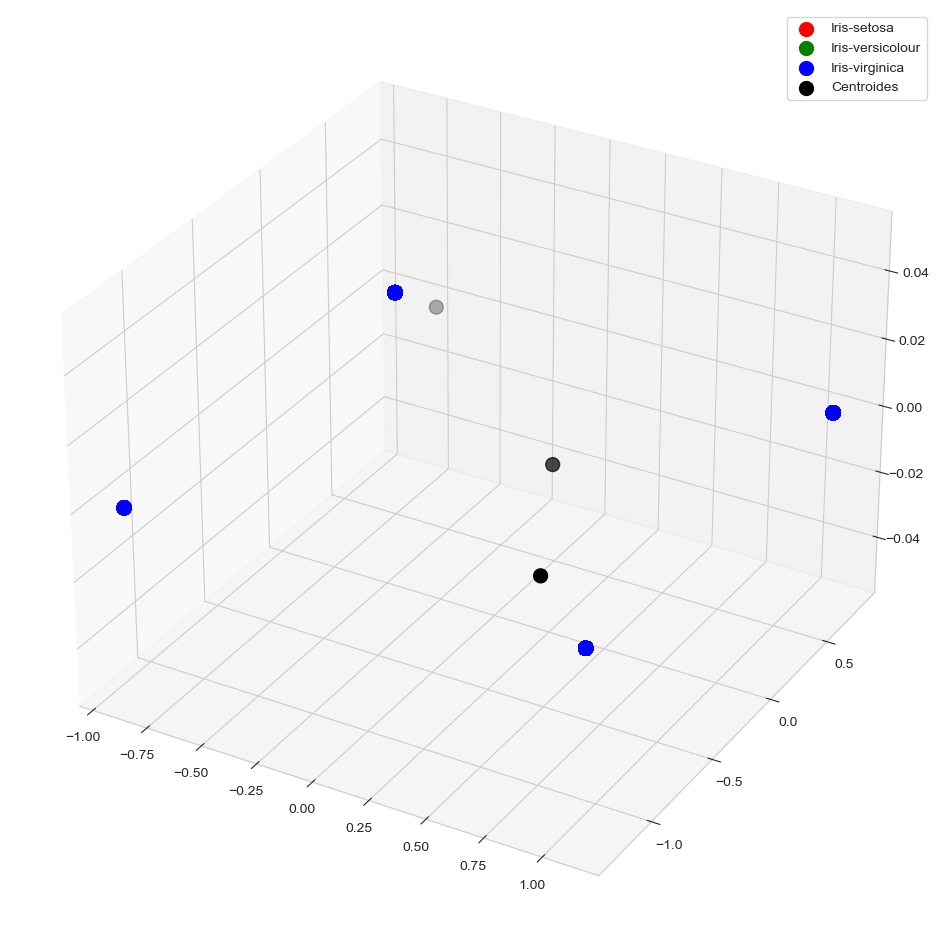

In [304]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_titanic[y_kmeans_titanic == 2, 0], X_titanic[y_kmeans_titanic == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_titanic.cluster_centers_[:, 0], kmeans_titanic.cluster_centers_[:,1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

## Utilizando o algoritmo Meanshift

In [305]:
# IRIS
meanShift_iris = MeanShift()
meanShift_iris.fit(X_iris)

labels_iris = meanShift_iris.labels_
centros_iris = meanShift_iris.cluster_centers_
###############################################

###############################################
# TITANIC
meanShift_titanic = MeanShift()
meanShift_titanic.fit(X_titanic)

labels_titanic = meanShift_titanic.labels_
centros_titanic = meanShift_titanic.cluster_centers_

### Visualizando os Resultados

In [306]:
nro_de_clusters = len(np.unique(labels_iris))
print(f"Número estimado de clusters [iris] = {nro_de_clusters}", end = "\n")
print(f"Quantidade de labels = {len(centros_iris)}", end = "\n")

nro_de_clusters = len(np.unique(labels_titanic))
print(f"Número estimado de clusters [titanic] = {nro_de_clusters}", end = "\n")
print(f"Quantidade de labels = {len(centros_titanic)}", end = "\n")

Número estimado de clusters [iris] = 2
Quantidade de labels = 2
Número estimado de clusters [titanic] = 6
Quantidade de labels = 6


### Visualizando os resultados de forma gráfica

#### Dataset Iris

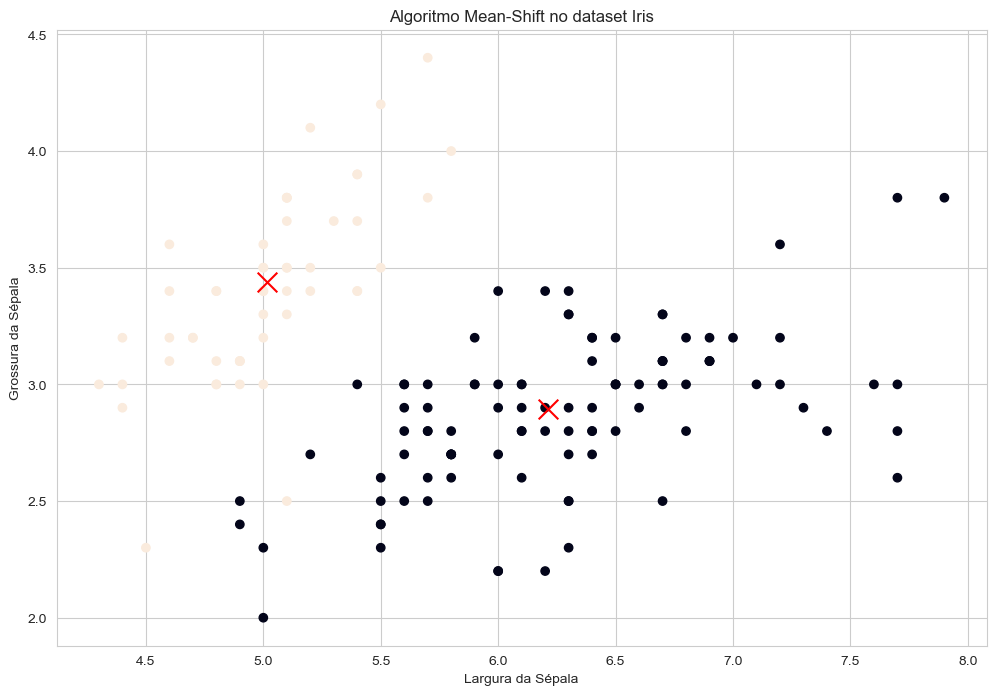

In [307]:
plt.figure(figsize = (12, 8))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c = labels_iris)
plt.scatter(centros_iris[:, 0], centros_iris[:, 1], marker = "x", color = "red", s = 200)
plt.xlabel("Largura da Sépala")
plt.ylabel("Grossura da Sépala")
plt.title("Algoritmo Mean-Shift no dataset Iris")
plt.show()

#### Dataset Titanic

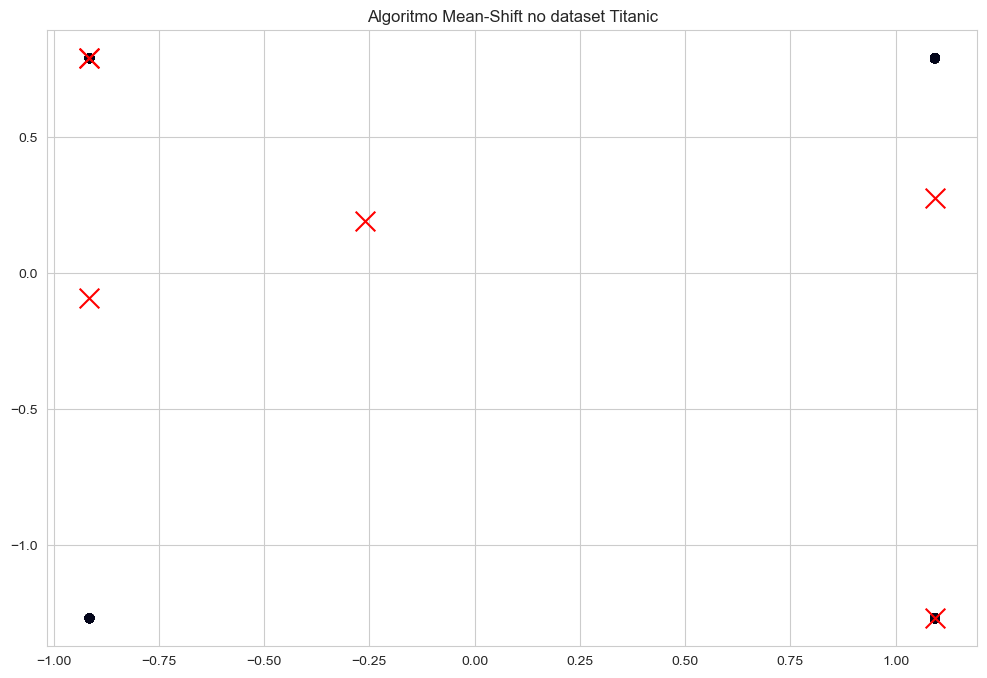

In [308]:
plt.figure(figsize = (12, 8))
plt.scatter(X_titanic[:, 0], X_titanic[:, 1], c = labels_titanic)
plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], marker = "x", color = "red", s = 200)
plt.title("Algoritmo Mean-Shift no dataset Titanic")
plt.show()

## Usando o algoritmo FuzzyCMeans

### Imprimindo o resultado dos testes - Dataset Iris

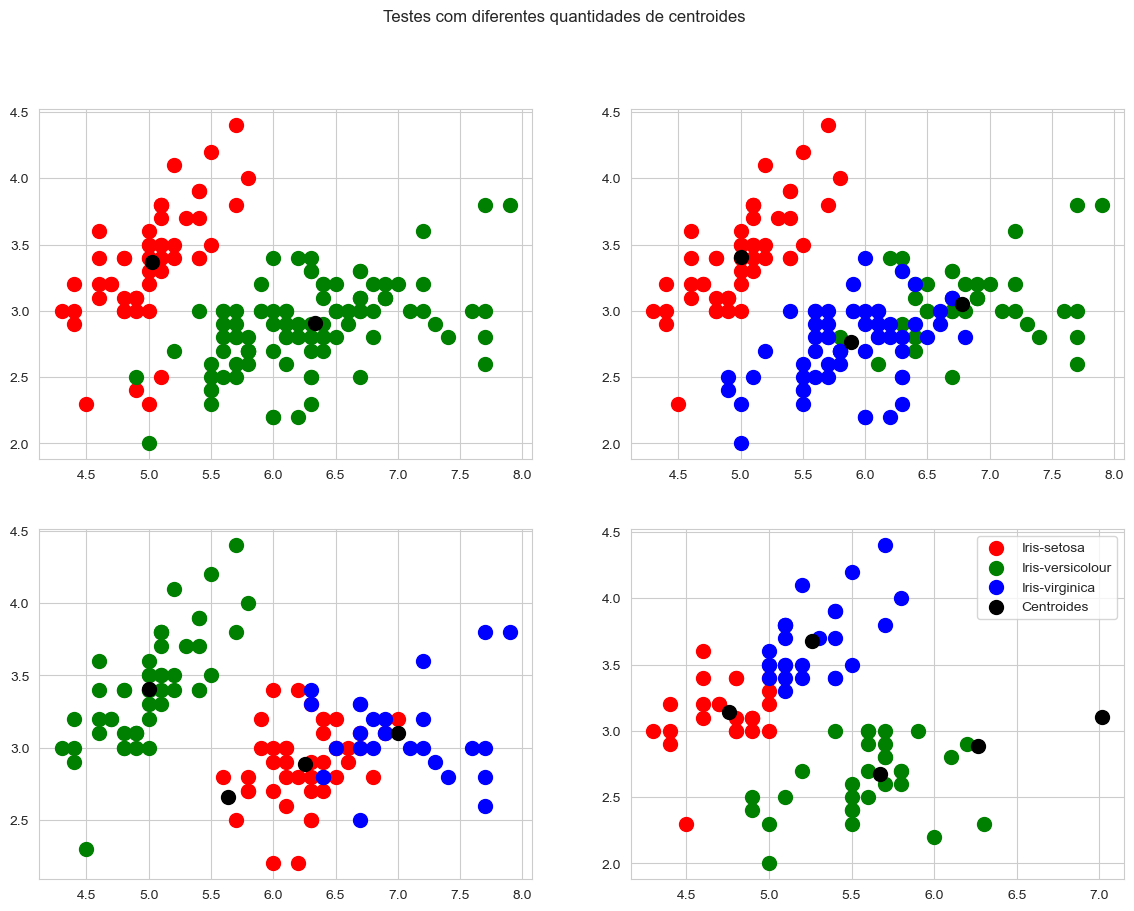

In [309]:
parametro_fuzzy = 2
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = parametro_fuzzy,
                 max_iter = nro_max_iteracoes,
                 n_init = nro_iteracoes_inicial,
                 random_state = semente_randomica)

    cmeans.fit(X_iris)
    y_cmeans = cmeans.predict(X_iris)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_iris[y_cmeans == 0, 0], X_iris[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
    eixos[j][k].scatter(X_iris[y_cmeans == 1, 0], X_iris[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
    eixos[j][k].scatter(X_iris[y_cmeans == 2, 0], X_iris[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, valor 3 é o que melhor descreve o conjunto dos pontos. Então será escolhido 3 como parâmetro para futuros testes no modelo

### Implementando a clusterização - Dataset Iris

In [310]:
parametro_fuzzy = 2
nro_de_clusters = 3

cmeans_iris = FCM(n_clusters = nro_de_clusters,
                m = parametro_fuzzy,
                max_iter = nro_max_iteracoes,
                n_init = nro_iteracoes_inicial,
                random_state = semente_randomica)

cmeans_iris.fit(X_iris)
y_cmeans_iris = cmeans_iris.predict(X_iris)
centros_iris = cmeans_iris.centers

##### Visualizando os clusters

###### De forma 2D

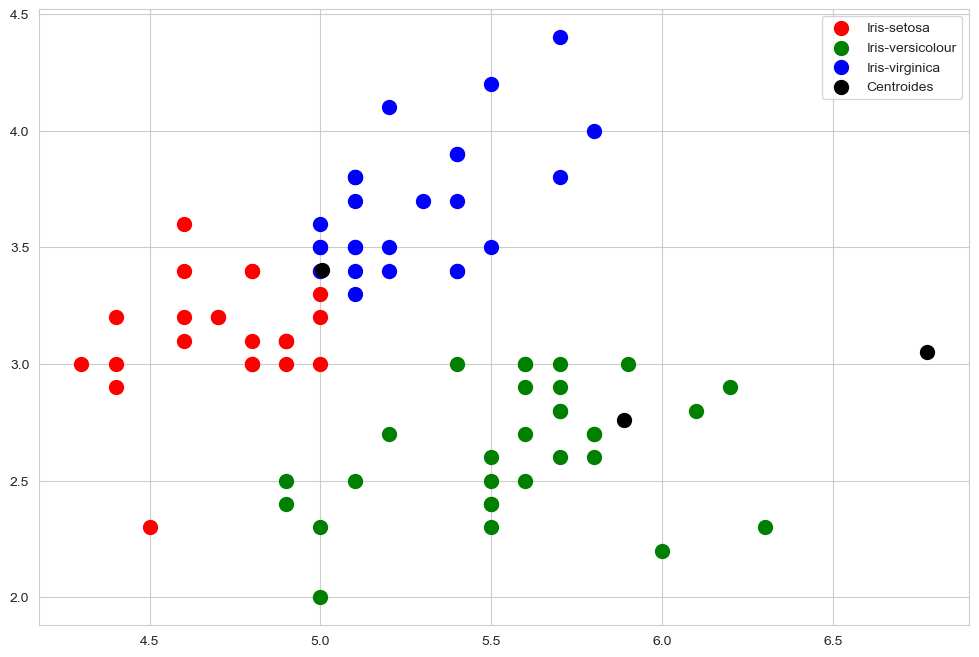

In [311]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_iris[y_cmeans == 0, 0], X_iris[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_cmeans == 1, 0], X_iris[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_cmeans == 2, 0], X_iris[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES

plt.scatter(centros_iris[:, 0], centros_iris[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

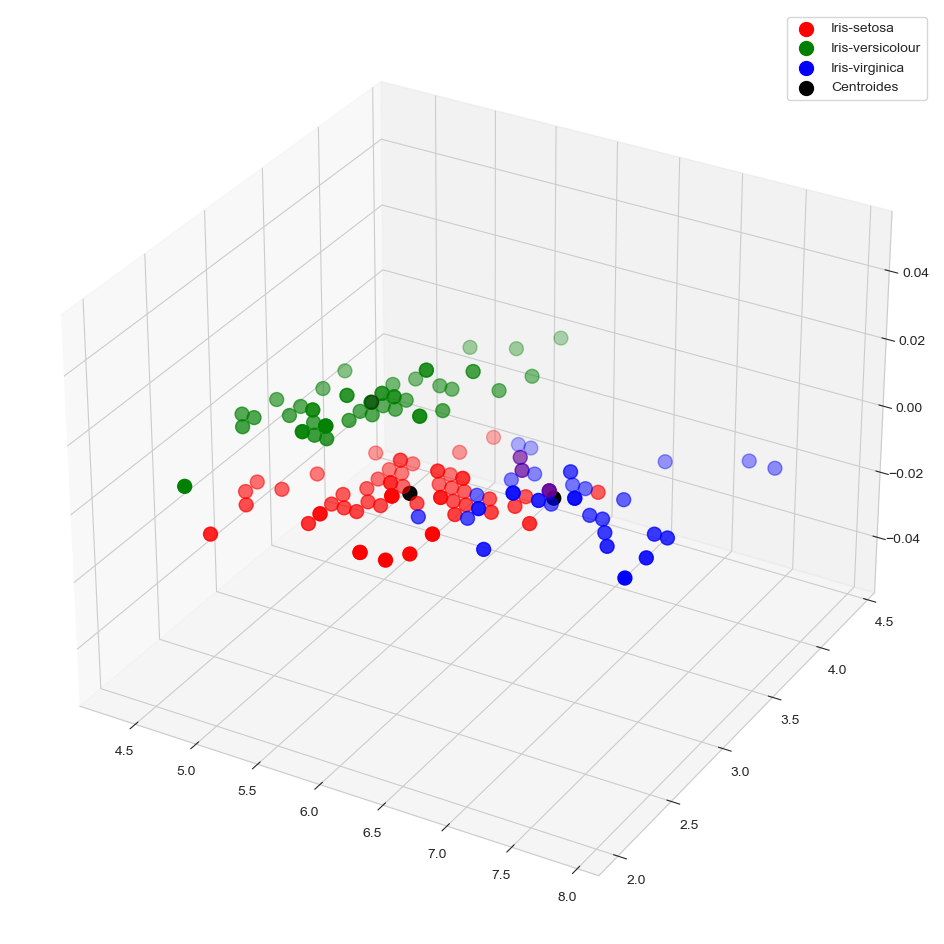

In [312]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(centros_iris[:, 0], centros_iris[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

### Imprimindo o resultado dos testes - Dataset Titanic

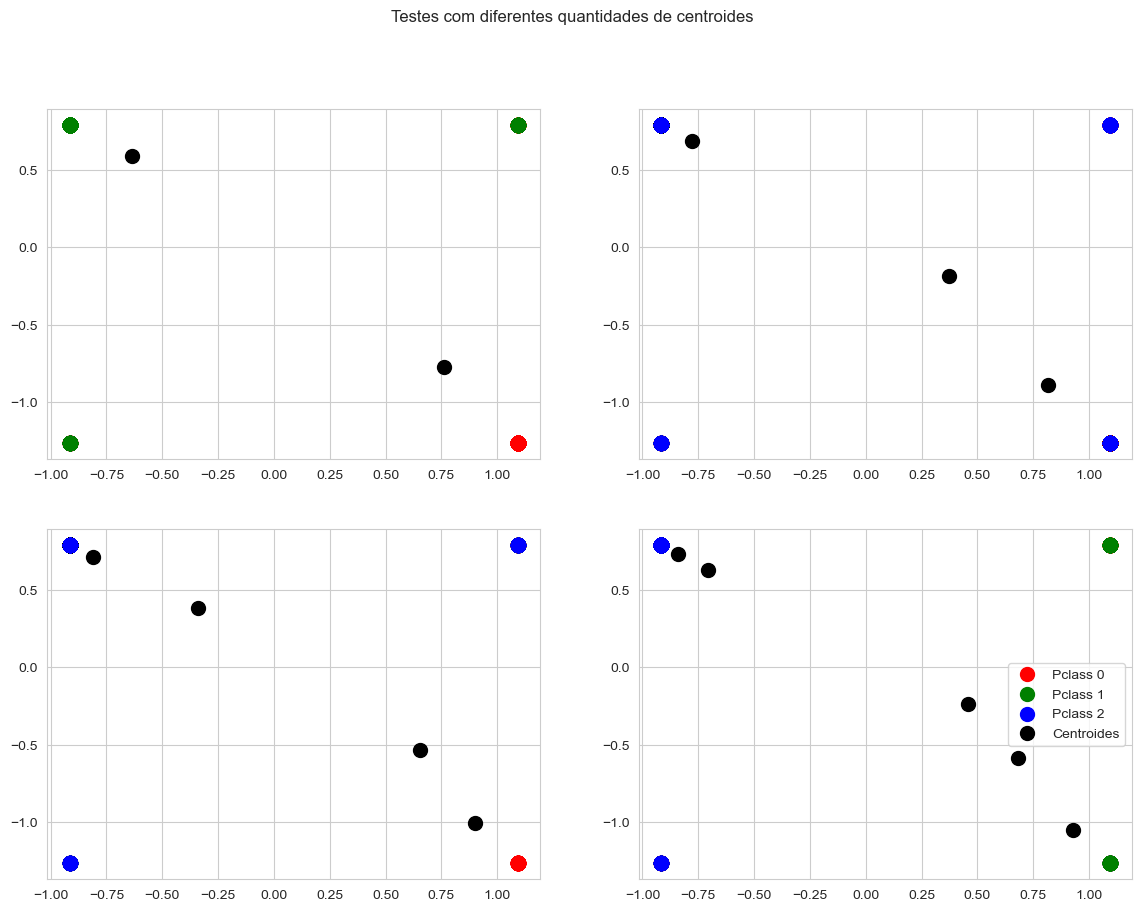

In [313]:
parametro_fuzzy = 2
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = parametro_fuzzy,
                 max_iter = nro_max_iteracoes,
                 n_init = nro_iteracoes_inicial,
                 random_state = semente_randomica)

    cmeans.fit(X_titanic)
    y_cmeans = cmeans.predict(X_titanic)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_titanic[y_cmeans == 0, 0], X_titanic[y_cmeans == 0, 1], s = 100, c = "red", label = "Pclass 0")
    eixos[j][k].scatter(X_titanic[y_cmeans == 1, 0], X_titanic[y_cmeans == 1, 1], s = 100, c = "green", label = "Pclass 1")
    eixos[j][k].scatter(X_titanic[y_cmeans == 2, 0], X_titanic[y_cmeans == 2, 1], s = 100, c = "blue", label = "Pclass 2")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, nenhum valor descreve melhor o conjunto dos pontos.
Mas será escolhido 3 como parâmetro para futuros testes no modelo, pois já sabemos que há 3 clusters

### Implementando a clusterização - Dataset Titanic

In [314]:
parametro_fuzzy = 2
nro_de_clusters = 3

cmeans_titanic = FCM(n_clusters = nro_de_clusters,
                    m = parametro_fuzzy,
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)

cmeans_titanic.fit(X_titanic)
y_cmeans_titanic = cmeans_titanic.predict(X_titanic)
centros_titanic = cmeans_titanic.centers

##### Visualizando os clusters

###### De forma 2D

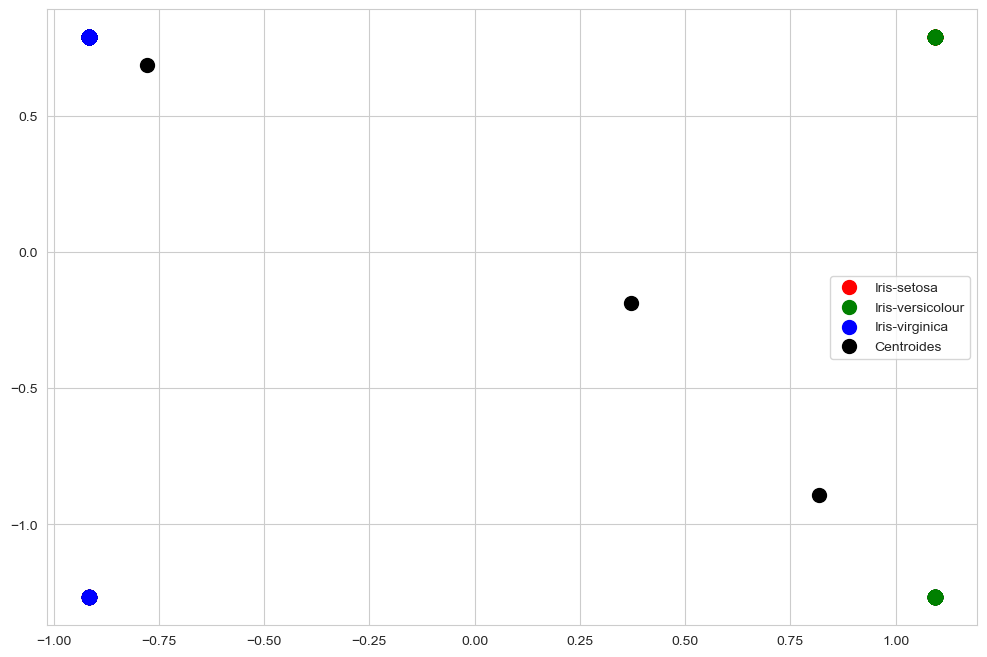

In [315]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_cmeans == 0, 0], X_titanic[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_titanic[y_cmeans == 1, 0], X_titanic[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_titanic[y_cmeans == 2, 0], X_titanic[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES

plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

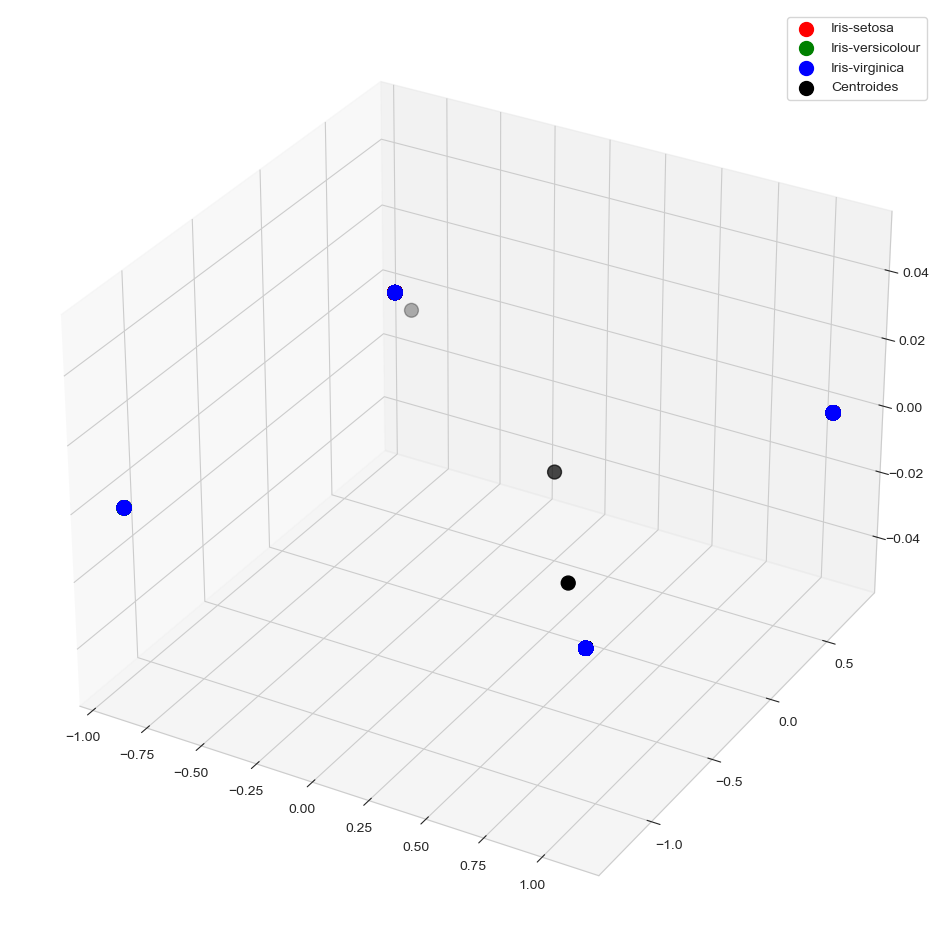

In [316]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_titanic[y_kmeans_titanic == 2, 0], X_titanic[y_kmeans_titanic == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

## Bibliografia

### SCIKIT-LEARN
- https://scikit-learn.org/stable/

### SCIKIT-LEARN.KMEANS
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### SCIKIT-LEARN.MEANSHIFT
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

### FUZZY_C_MEANS
- https://pypi.org/project/fuzzy-c-means/
	- https://github.com/omadson/fuzzy-c-means
- https://github.com/ShristiK/Fuzzy-C-Means-Clustering
- https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
- https://www.kaggle.com/code/prateekk94/fuzzy-c-means-clustering-on-iris-dataset
- https://fda.readthedocs.io/en/latest/index.html
	- https://fda.readthedocs.io/en/latest/modules/ml/autosummary/skfda.ml.clustering.FuzzyCMeans.html
